In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.compat.v1.enable_eager_execution()

In [5]:
inputs_train = np.load("inputs_train.npy")
inputs_test = np.load("inputs_test.npy")

In [6]:
inputs_train = np.transpose(inputs_train, (0, 2,3,1))
inputs_test = np.transpose(inputs_test, (0, 2,3,1))

In [7]:
inputs_train = inputs_train.reshape(inputs_train.shape[:2] + (inputs_train.shape[2]*inputs_train.shape[3],))
inputs_test = inputs_test.reshape(inputs_test.shape[:2] + (inputs_test.shape[2]*inputs_test.shape[3],))

In [8]:
train = pd.read_csv('train_timeframes.csv').iloc[59:]
test = pd.read_csv('test_timeframes.csv').iloc[59:]

In [9]:
df = [train, test]

In [10]:
img = inputs_train[0,:,:]

In [11]:
inputs_train.shape, train.shape

((73695, 60, 20), (73695, 23))

In [12]:
inputs_test.shape, test.shape

((24365, 60, 20), (24365, 23))

In [13]:
idx = 0
batch_size = 32
stop_limit = 0.004
price_limit = 0.004
margin_size = 50
time_limit = 60

In [14]:
model = models.Sequential()
# model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
model.add(LSTM(32, input_shape = img.shape, dropout=0.2))
# model.add(LSTM(32, dropout=0.2))
model.add(Dense(3, activation = "sigmoid"))

In [15]:
# model = models.Sequential()

# model.add(Conv2D(32, (5, 1),padding ='Same', activation='relu', input_shape = img.shape))
# model.add(Conv2D(32, (5, 1),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D((2, 1)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,(3, 1),padding = 'Same', activation ='relu'))
# model.add(Conv2D(64, (3, 1),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation = "sigmoid"))

In [16]:
model = tf.keras.models.load_model('max_profit_model/', compile=False)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6784      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 6,883
Trainable params: 6,883
Non-trainable params: 0
_________________________________________________________________


In [18]:
def custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit):    
    def custom_metric(y_true, y_pred):
        margin = ((y_pred[:,:1] - 0.5) * 2)
        margin *= margin_size
        direction = tf.sign(margin)
        stop_loss = y_pred[:,1:2] * direction * -1 * stop_limit
        price_target = y_pred[:,2:3] * direction * 1 * price_limit
        
        idx = y_true[0].numpy()[1]
        df_name = int(y_true[0].numpy()[0])
        batch_size = y_pred.shape[0]
        closes = []
        spread = []
        values = df[df_name].iloc[int(idx):int(idx+batch_size+time_limit)][['close_1min', 'spread']].values
        closes = tf.convert_to_tensor([values[i:-batch_size+i,0] for i in range(batch_size)])
        spread = tf.convert_to_tensor([values[i:-batch_size+i,1] for i in range(batch_size)])
#         for i in range(batch_size):
#             closes.append(df[df_name].iloc[int(idx+i):int(idx+i+time_limit)]['close_1min'].tolist())
#             spread.append(df[df_name].iloc[int(idx+i):int(idx+i+time_limit)]['spread'].tolist())
            
#         closes = tf.convert_to_tensor(closes)
#         spread = tf.convert_to_tensor(spread)
#         spread *= direction
        
        close1 = closes[:,:1]
        close2 = tf.zeros_like(closes[:,:1])
        for i in range(1, closes.shape[1]):
            diff = (closes[:,i:i+1] - closes[:,:1]) * direction
            cond = tf.logical_or(tf.less(diff, stop_loss), tf.greater(diff, price_target))
            close2 = tf.where(tf.logical_and(tf.equal(close2, 0), cond), closes[:,i:i+1], close2)
            
        close2 = tf.where(tf.equal(close2, 0), closes[:,-1:], close2)

        diff = close2 - close1
        profit = 100 * (margin * (diff - spread)) /  close1
        return profit
    return custom_metric

def custom_loss_wrapper(idx, stop_limit, price_limit, margin_size, time_limit):    
    def custom_loss(y_true, y_pred):
#         print()
        margin = ((y_pred[:,:1] - 0.5) * 2)
        margin *= margin_size
        direction = tf.sign(margin)
        stop_loss = y_pred[:,1:2] * direction * -1 * stop_limit
        price_target = y_pred[:,2:3] * direction * 1 * price_limit
        
        idx = y_true[0][1].numpy()
        df_name = y_true[0][0].numpy()
        batch_size = y_pred.shape[0]
        closes = []
        spread = []
#         values = df[df_name].iloc[int(idx):int(idx+batch_size+time_limit)][['close_1min', 'spread']].values
#         closes = tf.convert_to_tensor([values[i:-batch_size+i,0] for i in range(batch_size)], dtype='float32')
#         spread = tf.convert_to_tensor([values[i:-batch_size+i,1] for i in range(batch_size)], dtype='float32')
        i = tf.constant(0)
        while_condition = lambda i: tf.less(i, tf.constant(batch_size))
        def body(i):
            closes.append(df[df_name].iloc[int(idx+i.numpy()):int(idx+i.numpy()+time_limit)]['close_1min'].tolist())
            spread.append(df[df_name].iloc[int(idx+i.numpy()):int(idx+i.numpy()+time_limit)]['spread'].tolist())
            return [tf.add(i, 1)]
        r = tf.while_loop(while_condition, body, [i], parallel_iterations=batch_size, swap_memory=True)
        
#         for i in range(batch_size):
#             closes.append(df[df_name].iloc[int(idx+i):int(idx+i+time_limit)]['close_1min'].tolist())
#             spread.append(df[df_name].iloc[int(idx+i):int(idx+i+time_limit)]['spread'].tolist())
        closes = tf.convert_to_tensor(closes)
        spread = tf.convert_to_tensor(spread)
#         spread *= direction
        close1 = closes[:,:1]
#         print(y_pred[0].numpy())
#         print(margin[0].numpy()[0], stop_loss[0].numpy()[0], price_target[0].numpy()[0])
        close2 = tf.zeros_like(closes[:,:1])
        lower_bound = tf.minimum(stop_loss, price_target)
        upper_bound = tf.maximum(stop_loss, price_target)
#         for i in range(1, closes.shape[1]):
        i = tf.constant(0)
        while_condition = lambda i: tf.logical_and(tf.less(i, tf.constant(closes.shape[1])), tf.math.count_nonzero(close2).numpy() == close2.shape[0])
        def body(i):
#             if tf.math.count_nonzero(close2).numpy() == close2.shape[0]:
#                 break
            diff = (closes[:,i:i+1] - closes[:,:1]) * direction
            cond = tf.logical_or(tf.less(diff, lower_bound), tf.greater(diff, upper_bound))
            close2 = tf.where(tf.logical_and(tf.equal(close2, 0), cond), closes[:,i:i+1], close2)
            return [tf.add(i, 1)]
#         print(' ', i, lower_bound[0].numpy()[0], diff[0].numpy()[0], upper_bound[0].numpy()[0])
        r = tf.while_loop(while_condition, body, [i], parallel_iterations=closes.shape[1], swap_memory=True)
            
        close2 = tf.where(tf.equal(close2, 0), closes[:,-1:], close2)

        max_diff = tf.maximum(tf.reduce_max(closes[:,1:], axis=1, keepdims=True) - close1, close1 - tf.reduce_min(closes[:,1:], axis=1, keepdims=True))
        max_profit = 100 * (margin_size * (max_diff - spread)) /  close1
#         print(margin_size, max_diff[0].numpy()[0], spread[0].numpy()[0],  close1[0].numpy()[0], max_profit[0].numpy()[0], ((max_diff - spread) /  close1)[0].numpy()[0])
        
        diff = close2 - close1
        profit = 100 * (margin * (diff - (spread*direction))) /  close1
#         print(margin[0].numpy()[0], max_diff[0].numpy()[0], diff[0].numpy()[0], max_profit[0].numpy()[0], profit[0].numpy()[0])
        loss = tf.keras.losses.MSE(max_profit, profit)
#         print(loss[0].numpy(), profit[0].numpy()[0], max_profit[0].numpy()[0], max_diff[0].numpy()[0])
#         print(margin[0].numpy()[0], close1[0].numpy()[0], close2[0].numpy()[0], spread[0].numpy()[0], loss[0].numpy(), profit[0].numpy()[0])
#         return tf.reduce_min(loss)
        return loss
    return custom_loss

In [19]:
def get_profit(data, y_preds, margin_lower_limit=0):
    idx = 0
    profits = []
    while idx < len(y_preds) - 1:
        margin = ((y_preds[idx][0] - 0.5) * 2)
        margin *= margin_size
        if abs(margin) < margin_lower_limit:
            idx += 1
        else:
            direction = np.sign(margin)
            stop_loss = y_preds[idx][1] * direction * -1 * stop_limit
            price_target = y_preds[idx][2] * direction * 1 * price_limit

            start_idx = idx
            close1 =  data.iloc[idx]['close_1min']
            spread = data.iloc[idx]['spread']
            idx += 1
            new_i = idx
            while new_i < len(data) - 1 and new_i - start_idx < time_limit:
                close2 = data.iloc[new_i]['close_1min']
                diff = (close2 - close1) 
                if min(stop_loss, price_limit) < diff * direction < max(stop_loss, price_limit):
                    break
                new_i += 1
            profit = 100 * (margin * (diff - (spread*direction))) /  close1
#             print(profit)
            profits.append(profit)
#             break
    return profits

# data = df[]

In [20]:
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
#             score = np.mean(custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)(tf.convert_to_tensor(self.y_val), tf.convert_to_tensor(y_pred)))
            profits = get_profit(df[1], y_pred)
            profits_0 = get_profit(df[1], y_pred, 0)
            print("interval evaluation - epoch: {:d} - score: {:.6f} -- score_0: {:.6f}".format(epoch, profits, profits_0))
           
buffer = (batch_size+time_limit) + 1000
ival = IntervalEvaluation(validation_data=(inputs_test[:-buffer], np.array([[1, i] for i in range(len(test)-buffer)])), interval=8)

In [21]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=custom_loss_wrapper(idx, stop_limit, price_limit, margin_size, time_limit),
#     metrics=[custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)],
    run_eagerly=True
)

In [ ]:
history = model.fit(inputs_train[:-buffer], np.array([[0, i] for i in range(len(train)-buffer)]), 
                    validation_data=(inputs_test[:-buffer], np.array([[1, i] for i in range(len(test)-buffer)])),
                    epochs=1000, shuffle=False,
                    batch_size=batch_size,
                    callbacks=[ival],
                   use_multiprocessing=True, verbose=1, validation_freq=10,
                    workers=32,
                   initial_epoch=246,
                   )

Epoch 247/1000
2269/2269 [==============================] - 441s 194ms/step - loss: 99.8659
Epoch 248/1000
2269/2269 [==============================] - 433s 191ms/step - loss: 97.8646
Epoch 249/1000
2269/2269 [==============================] - 435s 192ms/step - loss: 99.2183
interval evaluation - epoch: 248 - score: -1695.924388 -- score_0: -1692.293508
Epoch 250/1000
2269/2269 [==============================] - 496s 218ms/step - loss: 98.4998 - val_loss: 108.5193
Epoch 251/1000
2269/2269 [==============================] - 441s 194ms/step - loss: 98.3469
Epoch 252/1000
2269/2269 [==============================] - 438s 193ms/step - loss: 95.3807
Epoch 253/1000
2269/2269 [==============================] - 440s 194ms/step - loss: 98.5044
Epoch 254/1000
2269/2269 [==============================] - 453s 199ms/step - loss: 99.9155
Epoch 255/1000
2269/2269 [==============================] - 439s 194ms/step - loss: 96.6683
Epoch 256/1000
2269/2269 [==============================] - 439s 194ms/

2269/2269 [==============================] - 629s 277ms/step - loss: 77.4579
Epoch 404/1000
2269/2269 [==============================] - 552s 243ms/step - loss: 82.3628
Epoch 405/1000
2269/2269 [==============================] - 544s 240ms/step - loss: 78.8643
Epoch 406/1000
2269/2269 [==============================] - 548s 242ms/step - loss: 78.1684
Epoch 407/1000
2269/2269 [==============================] - 548s 241ms/step - loss: 80.5648
Epoch 408/1000
2269/2269 [==============================] - 546s 241ms/step - loss: 74.0703
Epoch 409/1000
2269/2269 [==============================] - 552s 243ms/step - loss: 77.3562
interval evaluation - epoch: 408 - score: -1777.816759 -- score_0: -1785.342823
Epoch 410/1000
2269/2269 [==============================] - 600s 264ms/step - loss: 82.1460 - val_loss: 122.8402
Epoch 411/1000
2269/2269 [==============================] - 550s 242ms/step - loss: 75.7160
Epoch 412/1000
2269/2269 [==============================] - 550s 242ms/step - loss: 75

2269/2269 [==============================] - 665s 293ms/step - loss: 72.2706
Epoch 483/1000
2269/2269 [==============================] - 664s 292ms/step - loss: 70.0837
Epoch 484/1000
2269/2269 [==============================] - 665s 293ms/step - loss: 73.0523
Epoch 485/1000
2269/2269 [==============================] - 665s 293ms/step - loss: 70.6666
Epoch 486/1000
2269/2269 [==============================] - 661s 292ms/step - loss: 69.3538
Epoch 487/1000
2269/2269 [==============================] - 662s 292ms/step - loss: 72.2256
Epoch 488/1000
2269/2269 [==============================] - 663s 292ms/step - loss: 70.2971
Epoch 489/1000
2269/2269 [==============================] - 662s 292ms/step - loss: 73.1364
interval evaluation - epoch: 488 - score: -1806.869994 -- score_0: -1786.473049
Epoch 490/1000
2269/2269 [==============================] - 725s 319ms/step - loss: 68.9439 - val_loss: 123.5027
Epoch 491/1000
2269/2269 [==============================] - 690s 304ms/step - loss: 69

In [217]:
model.save('max_profit_model')

INFO:tensorflow:Assets written to: max_profit_model\assets


INFO:tensorflow:Assets written to: max_profit_model\assets


In [22]:
y_preds = {'train': model.predict(inputs_train[:-buffer]), 'test': model.predict(inputs_test[:-buffer])}

In [23]:
profits = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [24]:
temp = {'train': train.iloc[:-buffer-1].copy(), 'test': test.iloc[:-buffer-1].copy()}
temp['train']['profit'] = profits['train']
temp['test']['profit'] = profits['test']

<AxesSubplot:>

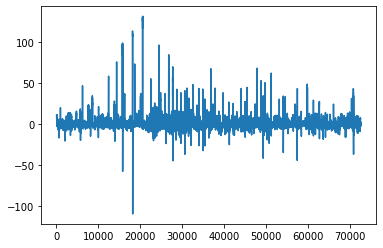

In [25]:
temp['train']['profit'].plot()

<AxesSubplot:>

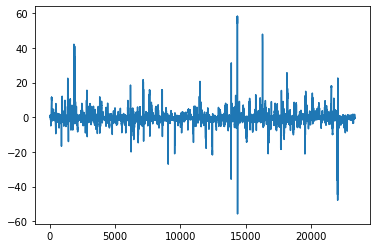

In [26]:
temp['test']['profit'].plot()

<AxesSubplot:>

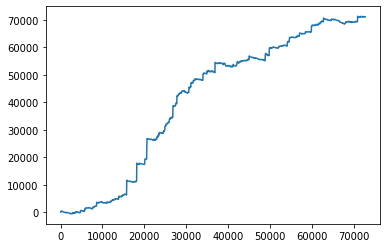

In [27]:
temp['train']['profit'].cumsum().plot()

<AxesSubplot:>

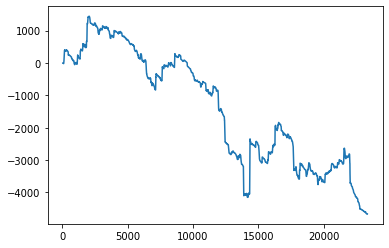

In [28]:
temp['test']['profit'].cumsum().plot()

In [29]:
sum(profits['train'])

71055.52862738771

In [30]:
sum(profits['test'])

-4662.037886953231

In [31]:
(252 ** 0.5) * np.mean(profits['train']) / np.std(profits['train'])

1.9735155647931983

In [32]:
(252 ** 0.5) * np.mean(profits['test']) / np.std(profits['test'])

-0.7600603775936591